## This is a notebook to analyse neural responses to sound presentations. 
Ephys data is recorded using openEphys

Sound presentation is done with bpod and matlab

During sound presentation a ttl is sent to openEphys from bpod itself

In [1]:
# Add modules to the path
import sys
sys.path.insert(0, '/mnt/c/Users/herny/OneDrive/Documents/GitHub/')

In [2]:
# Import helpers
%load_ext autoreload
%autoreload 2
from BehaviouralAnalysis.utils import data_reader
from BehaviouralAnalysis.utils.plot_utils import axvlines
import pyopenephys
import matplotlib.pylab as plt
from utils.custom_functions import getFirstPulses, update_progress, butter_bandpass, getTTLs, alignSpikes
import numpy as np
from scipy.signal import argrelextrema
import time
import pickle
from scipy.signal import butter, filtfilt
import os
import glob


### <br><br>Behavioural data

In [3]:
# Behavioral data
BehavPath = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/'
BehavFilePath = 'Green/Sound_Presentation/Session Data/Green_Sound_Presentation_20190305_101010.mat'
Behav_Data_Dict = data_reader.Bpod_Sound_Presentation(BehavPath + BehavFilePath)


In [4]:
stimulus_order = Behav_Data_Dict['Stimulus']

### <br><br>Ephys data

1. Referencing
2. High-pass filter 6/900-6000
2. Thresholding (uV (e.g. >25uV), SD, ...)
3. "Censoring" -> Imposing a refractory period to not find spikes twice (300us)

In [5]:
# run this cell and check down for the dataframe is data has been processed already
OEpath = '/mnt/c/Users/herny/Desktop/SWC/Data/Ephys_data/SoundResponses/RawData/'
Experiment = 'NN01_2019-10-28_16-52-33_SoundResponses_and_Stim'
#get animal name
AnimalName = Experiment.split('_')[0]
OutputPath = os.path.dirname(os.path.dirname(OEpath)) + '/AnalyzedData/' + AnimalName + '/'

OEfile = pyopenephys.File(OEpath + Experiment)

Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format


In [6]:
recording = OEfile.experiments[0].recordings[0]
print('Duration: ', recording.duration)
print('Sampling Rate: ', recording.sample_rate)

.dat:  continuous.dat
Estimated samples:  17524224  Numchan:  75
Duration:  584.1407666666667 1/Hz
Sampling Rate:  30000.0 Hz


##### <br>Indicate which channels are your electrodes and the sampling rate

In [7]:
ElectrodeChannels = range(64)
SamplingRate = recording.sample_rate.item()

##### <br>get TTLs

In [8]:
# get digital input (TTLs) CHECK THAT THE CHANNELS ARE CORRECT DEPENDING ON WHERE THE BNC CABLE IS CONNECTED TO
rawTTLs = getTTLs(recording.events[0])
if len(rawTTLs) == 1: #only sound responses
    BpodTTLs = rawTTLs[0]
    PulsepalTTLs = np.empty(0)
if len(rawTTLs) == 2: #sound and stimulation together
    BpodTTLs = rawTTLs[1]# sound
    PulsepalTTLs = rawTTLs[0]# stimulation

In [9]:
# classify the pulses and save them into a diccionary
soundPresentationTimes = getFirstPulses(BpodTTLs, 4) #Detect first events (separated by at least 4 seconds)
TTLs = {
        'soundPresentationTimes': soundPresentationTimes,
        'soundOffsetTimes': np.setdiff1d(BpodTTLs, soundPresentationTimes), #get sound offset
        'stimTimes': getFirstPulses(PulsepalTTLs, 0.01) #Detect all stimulation events
}

In [10]:
# get the analog signals
AnalogSignals = recording.analog_signals[0]

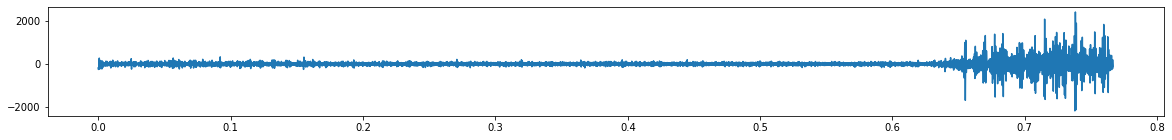

In [11]:
# plot analog signal of channel 4
fig_an, ax_an = plt.subplots(figsize=(20, 2))
#ax_an.plot(AnalogSignals.times[30000:31000], AnalogSignals.signal[3][30000:31000])
b,a = butter_bandpass(900, 6000, SamplingRate)
filtered = filtfilt(b, a, AnalogSignals.signal[3])
ax_an.plot(AnalogSignals.times[1:23000], filtered[1:23000])
#axvlines(BpodTTLs)
#plt.xlim(200, 200.1)
plt.show()


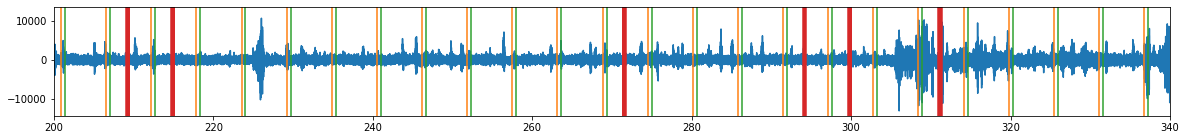

In [12]:
# plot pulses
fig_an, ax_an = plt.subplots(figsize=(20, 2))
ax_an.plot(AnalogSignals.times, AnalogSignals.signal[3])
axvlines(TTLs['soundPresentationTimes'])
axvlines(TTLs['soundOffsetTimes'])
axvlines(TTLs['stimTimes'])
plt.xlim(200, 340)
plt.show()

##### <br><br>Check that datasets match

In [13]:
if len(TTLs['soundPresentationTimes']) == len(stimulus_order):
    print('Datasets match')
else:
    print('Datasets do not match!!!')
    

Datasets match


##### <br><br>Get spikes from the ephys data

In [14]:
# Calculate the median of all channels
MedianSignal = np.median(AnalogSignals.signal[ElectrodeChannels], axis = 0)

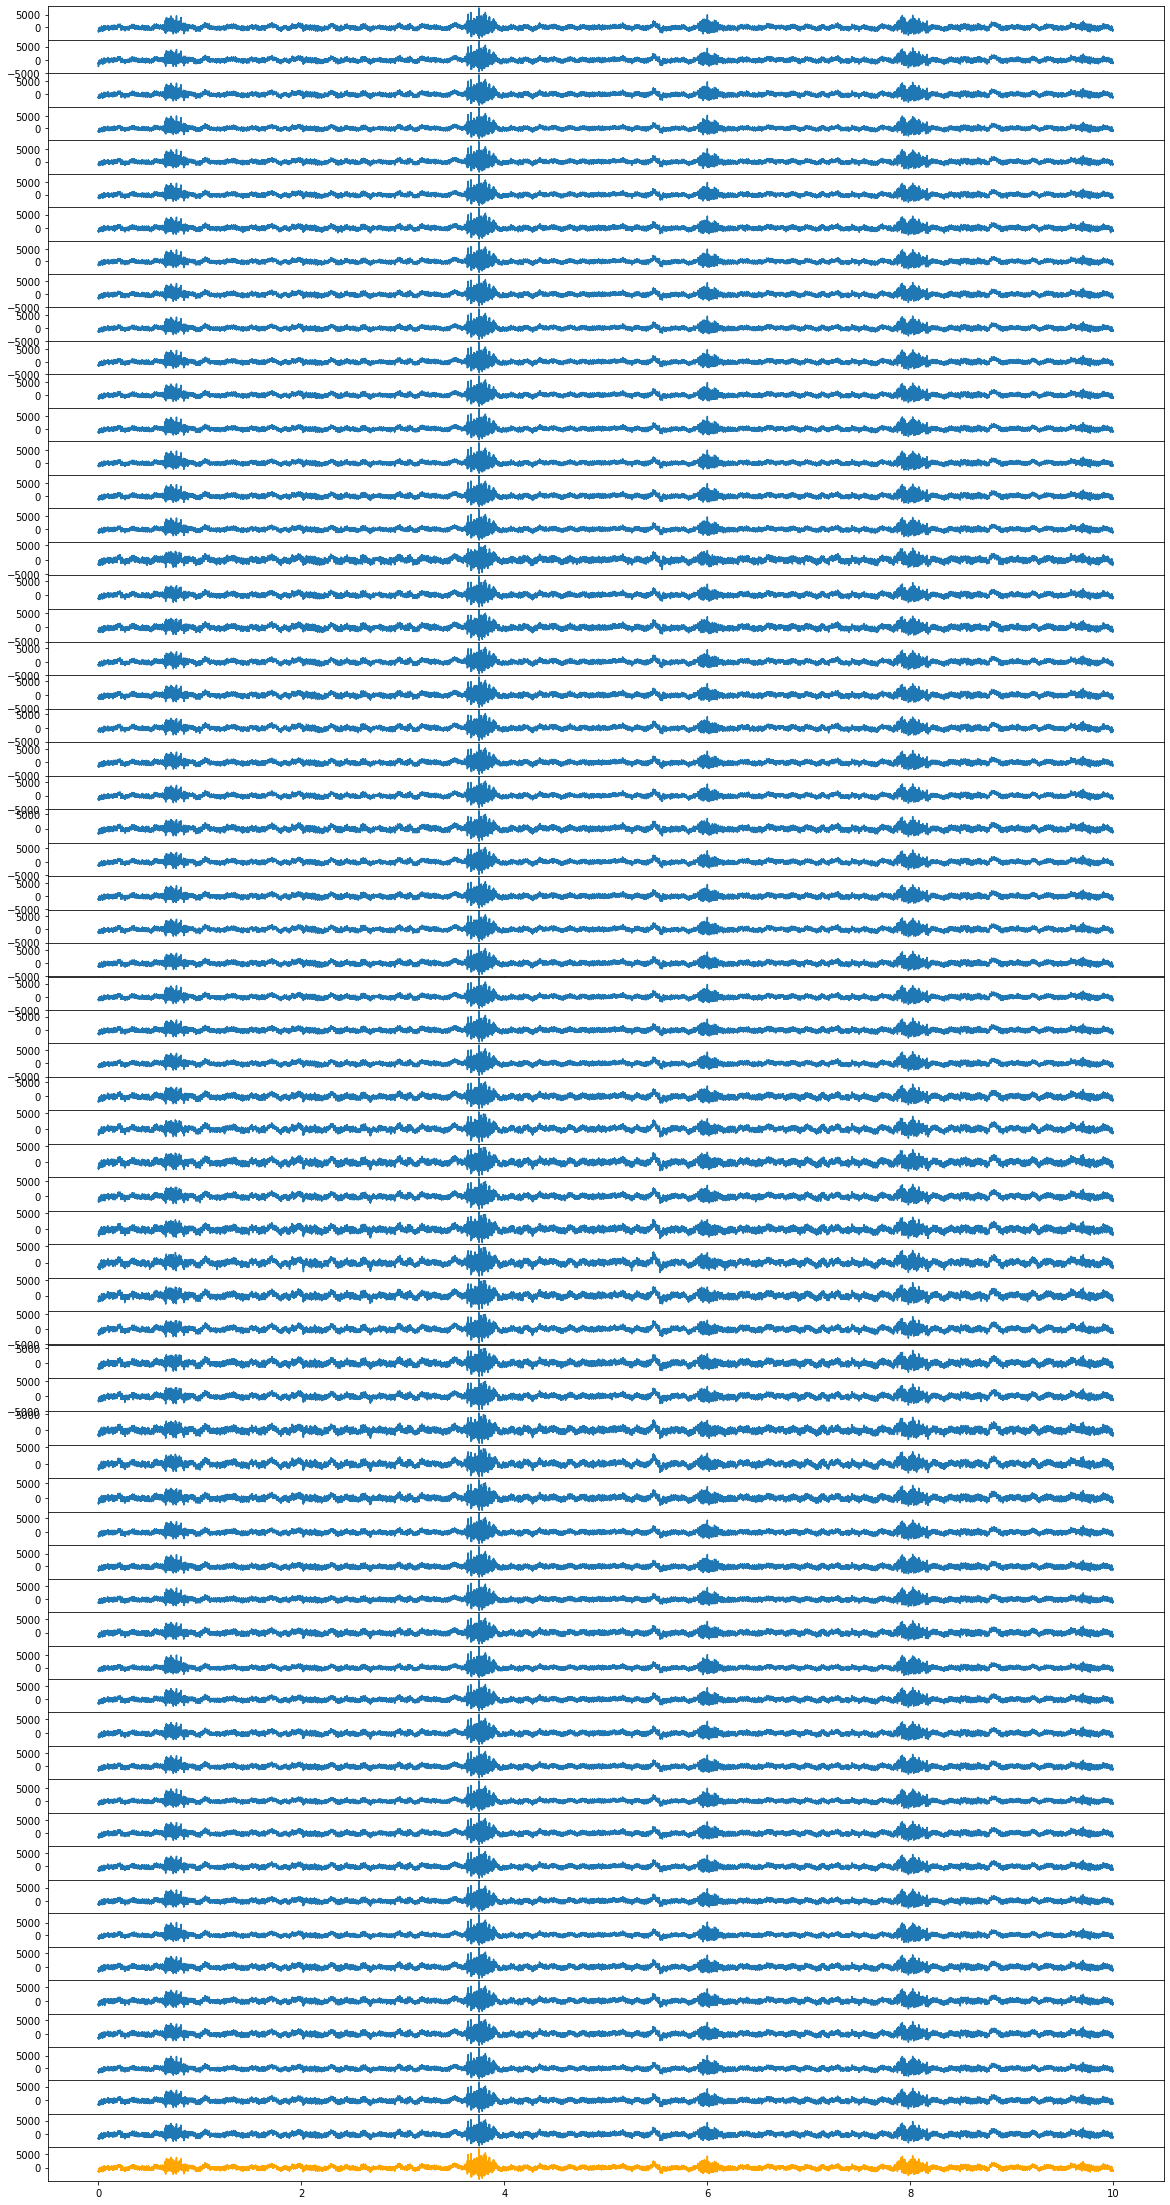

In [15]:
# [OPTIONAL] Sanity check
# Plot all channels and the median
PlotX = range(0, int(SamplingRate * 10)) #10s

fig, axs = plt.subplots(len(ElectrodeChannels)+1, 1, figsize=(20, 40) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in ElectrodeChannels:
    axs[i].plot(AnalogSignals.times[PlotX], AnalogSignals.signal[i][PlotX])
    #axs[i].text(.5,.9,"Channel Idx "+str(i), horizontalalignment='center', transform=axs[i].transAxes)
    
    #print(i)
axs[i+1].plot(AnalogSignals.times[PlotX], MedianSignal[PlotX], color = 'orange')
plt.show()

<IPython.core.display.Javascript object>


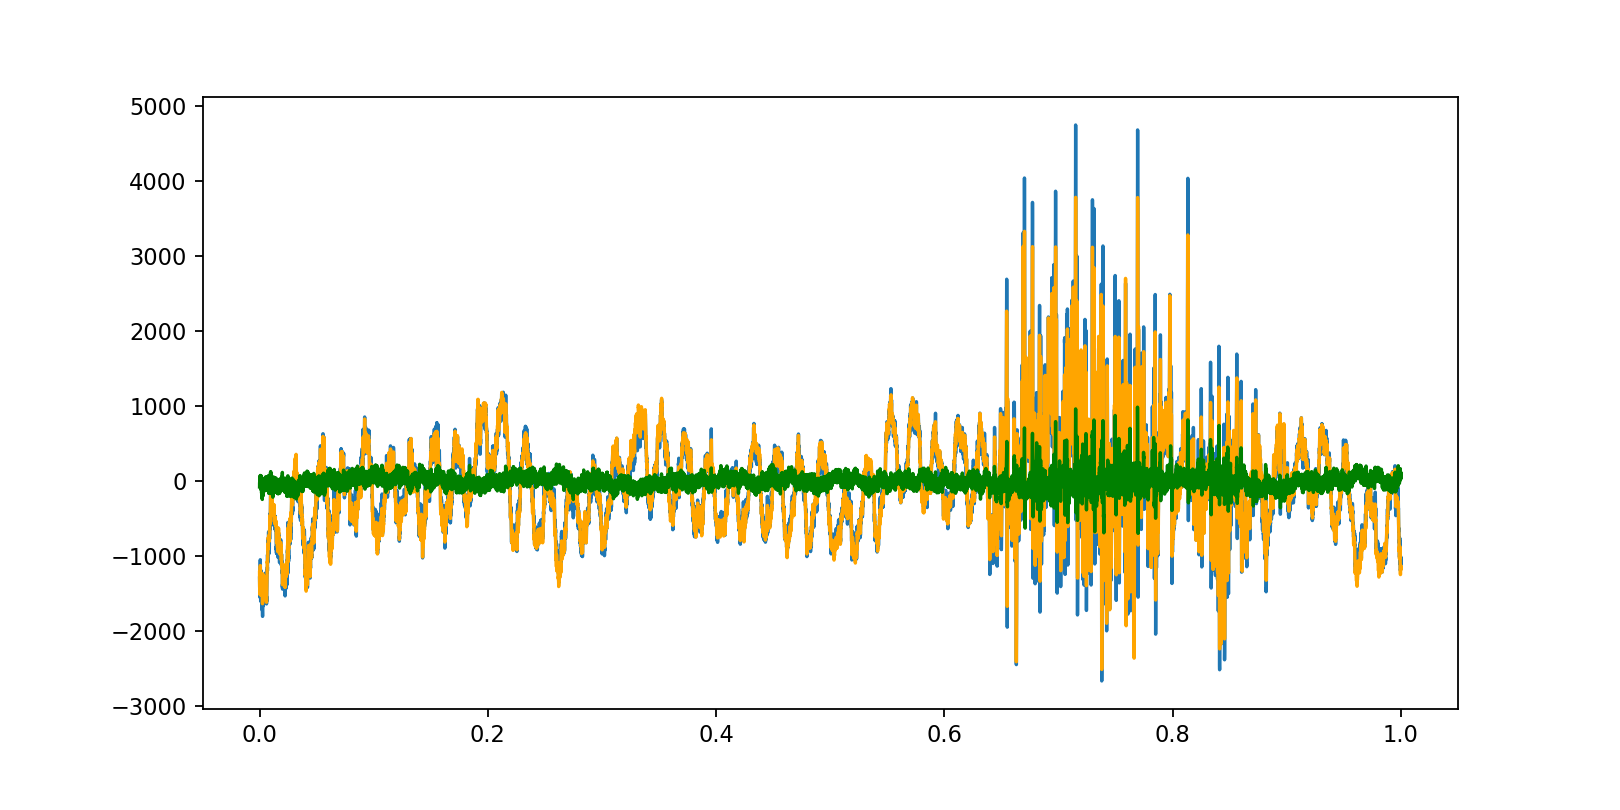

In [41]:
%matplotlib notebook

fig, axs = plt.subplots(figsize=(10, 5))
plt.plot(AnalogSignals.times[PlotX], AnalogSignals.signal[63][PlotX])
plt.plot(AnalogSignals.times[PlotX], MedianSignal[PlotX], color = 'orange')
plt.plot(AnalogSignals.times[PlotX], RefSignals[61][PlotX], color = 'green')
plt.show()

In [16]:
# Subtract the median from all channels
RefSignals = AnalogSignals.signal[ElectrodeChannels] - MedianSignal

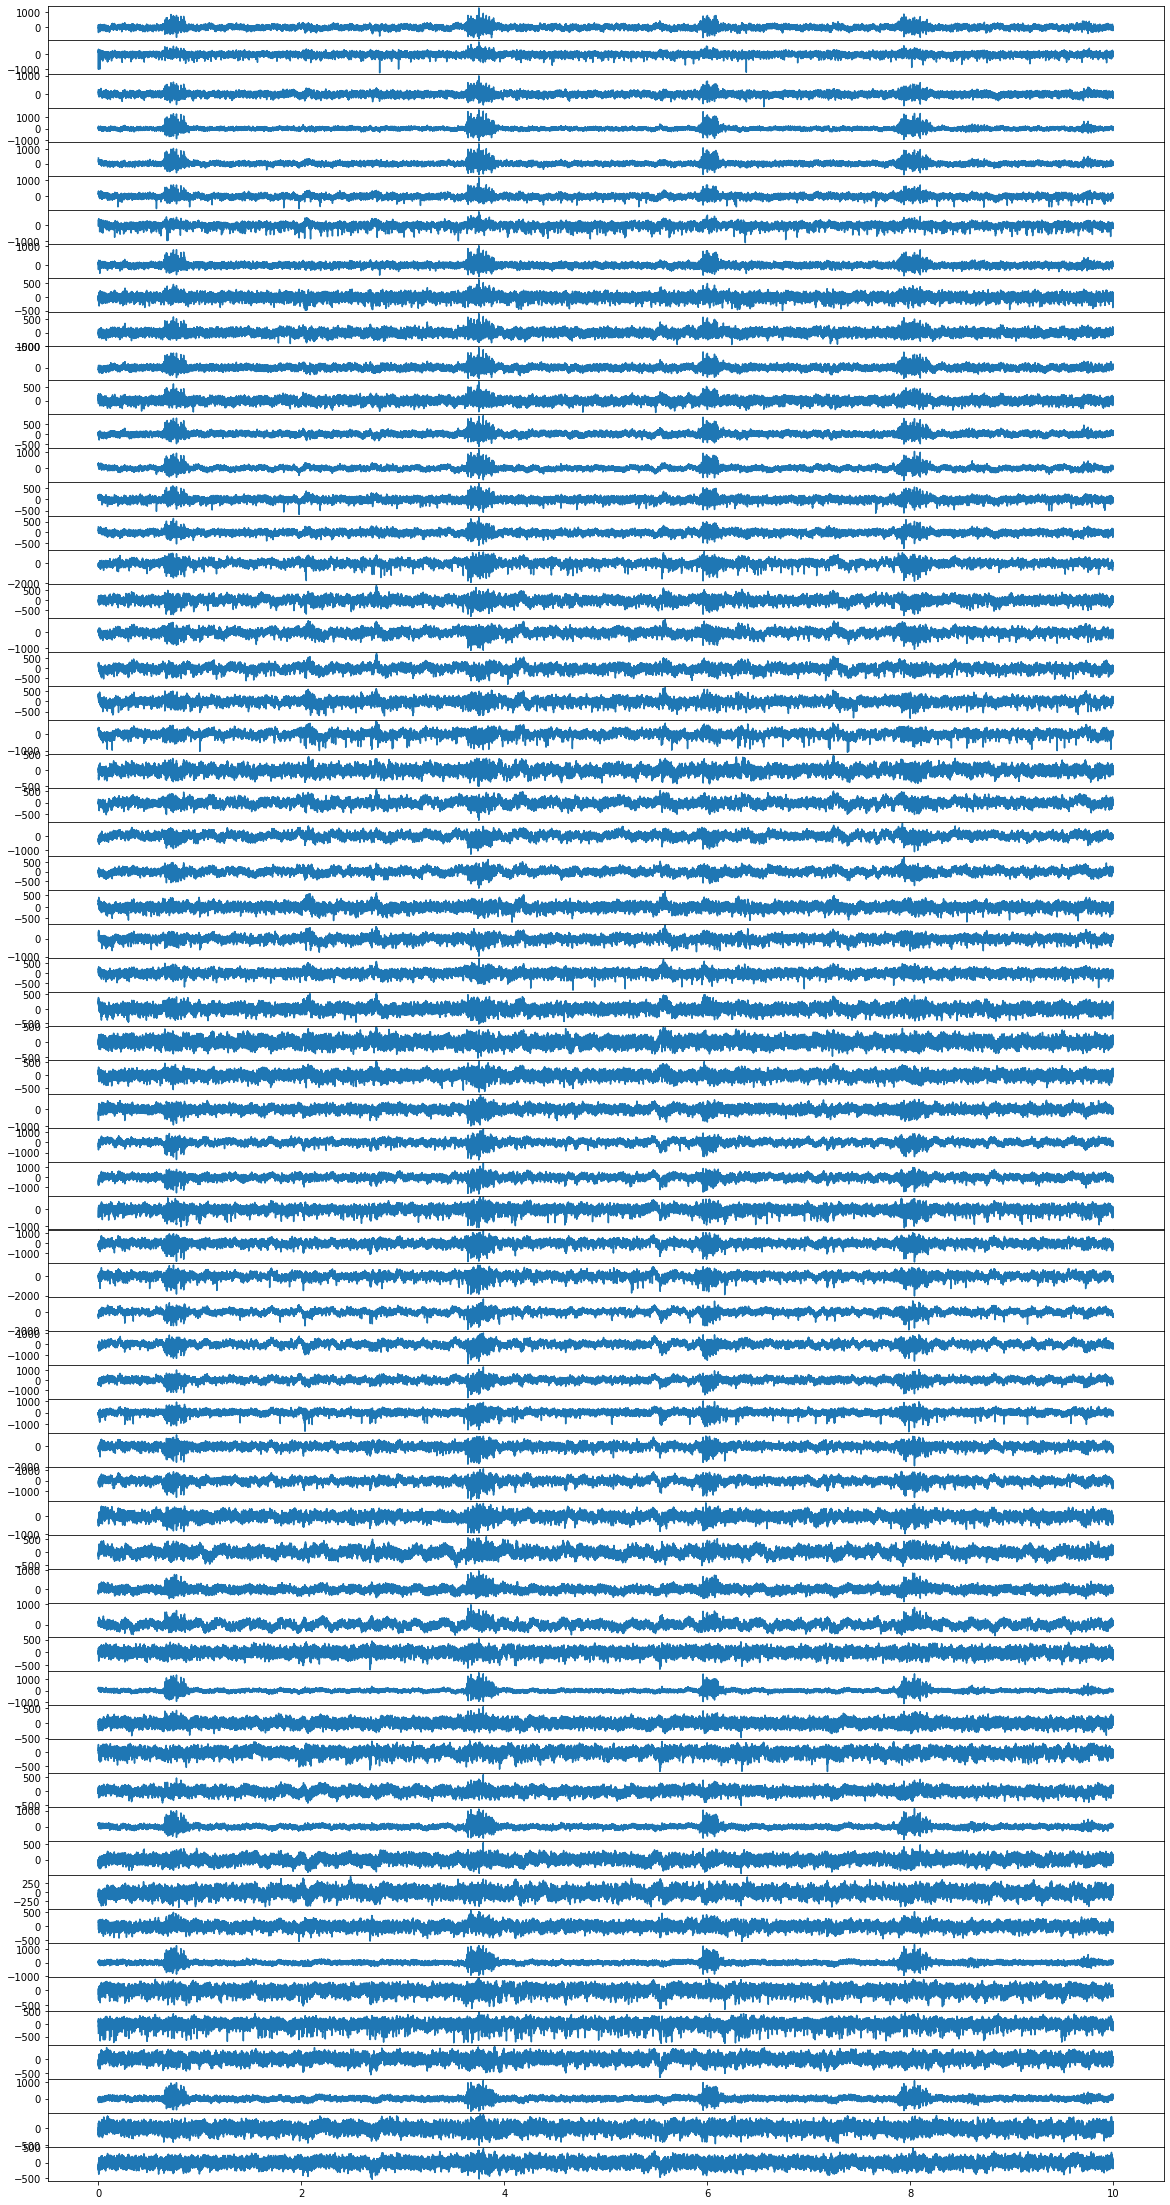

In [30]:
# [OPTIONAL] Sanity check
# Plot all channels subtracted
PlotX = range(0, int(SamplingRate * 10)) #10s

fig, axs = plt.subplots(len(ElectrodeChannels), 1, figsize=(20, 40) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in ElectrodeChannels:
    axs[i].plot(AnalogSignals.times[PlotX], RefSignals[i][PlotX])
    #axs[i].text(.5,.9,"Channel Idx "+str(i), horizontalalignment='center', transform=axs[i].transAxes)

plt.show()

In [17]:
# Band-pass filter the data
RSfilt = [None] * len(ElectrodeChannels)
b,a = butter_bandpass(900, 6000, SamplingRate)
for row in ElectrodeChannels:
    RSfilt[row] = filtfilt(b, a, RefSignals[row])
    update_progress(row / len(ElectrodeChannels))
update_progress(1)

Progress: [####################] 100.0%


In [18]:
# Compute the standard deviation of every channel
RefSignalsSD = [None] * len(ElectrodeChannels)
for i in range(len(ElectrodeChannels)):
    RefSignalsSD[i] = np.std(RSfilt[i])
    update_progress(i / len(ElectrodeChannels))
update_progress(1)

In [42]:
# Select a theshold cut-off
SD_cutoff = 4.5

In [43]:
# Plot
PlotX = range(0,30000) # 1s
fig, axs = plt.subplots(len(ElectrodeChannels), 1, figsize=(20, 100) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(len(ElectrodeChannels)):
    axs[i].plot(AnalogSignals.times[PlotX], RSfilt[i][PlotX])
    axs[i].text(.5,.9,"Channel Idx "+str(i), horizontalalignment='center', transform=axs[i].transAxes)
    # plot SD
    axs[i].axhline(SD_cutoff*RefSignalsSD[i], color = 'red')
    axs[i].axhline(-SD_cutoff*RefSignalsSD[i], color = 'red')
    
    update_progress(i / len(ElectrodeChannels))
update_progress(1)
plt.show()

Progress: [####################] 100.0%


In [44]:
# Detect threshold crossings
start = time.time()
SignalsSpikes = [None] * len(ElectrodeChannels)

for Channel in ElectrodeChannels:
    # Get the time points above/below the cutoff
    #SigMaxIdx = argrelextrema(Channel, np.greater)
    # above and below:
    Crossings = AnalogSignals.times[abs(RSfilt[Channel])>SD_cutoff*RefSignalsSD[Channel]]
    # below:
    #Crossings = AnalogSignals.times[RSfilt[Channel]<-SD_cutoff*RefSignalsSD[Channel]]

    # Get the first events in less than 1ms
    if len(Crossings)>0:
        SignalsSpikes[Channel] = getFirstPulses(Crossings, 0.001)
    
    update_progress(Channel / len(ElectrodeChannels))
update_progress(1)
    
print(start - time.time())

Progress: [####################] 100.0%
-508.040646314621


In [45]:
# Plot sanity check
PlotX = range(0,300000) #10s
fig, axs = plt.subplots(len(ElectrodeChannels), 1, figsize=(20, 60) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in ElectrodeChannels:
    axs[i].plot(AnalogSignals.times[PlotX], RSfilt[i][PlotX])
    #axs[i].text(.5,.9,"Channel Idx "+str(i), horizontalalignment='center', transform=axs[i].transAxes)
    # plot SD
    axs[i].axhline(SD_cutoff*RefSignalsSD[i], color = 'red')
    axs[i].axhline(-SD_cutoff*RefSignalsSD[i], color = 'red')
    axvlines(SignalsSpikes[i][(SignalsSpikes[i]>=AnalogSignals.times[PlotX][0]) & (SignalsSpikes[i]<=AnalogSignals.times[PlotX][-1])], alpha=0.3, ax = axs[i])
    #print(i)
    update_progress(i / len(ElectrodeChannels))
update_progress(1)
plt.show()

Progress: [####################] 100.0%


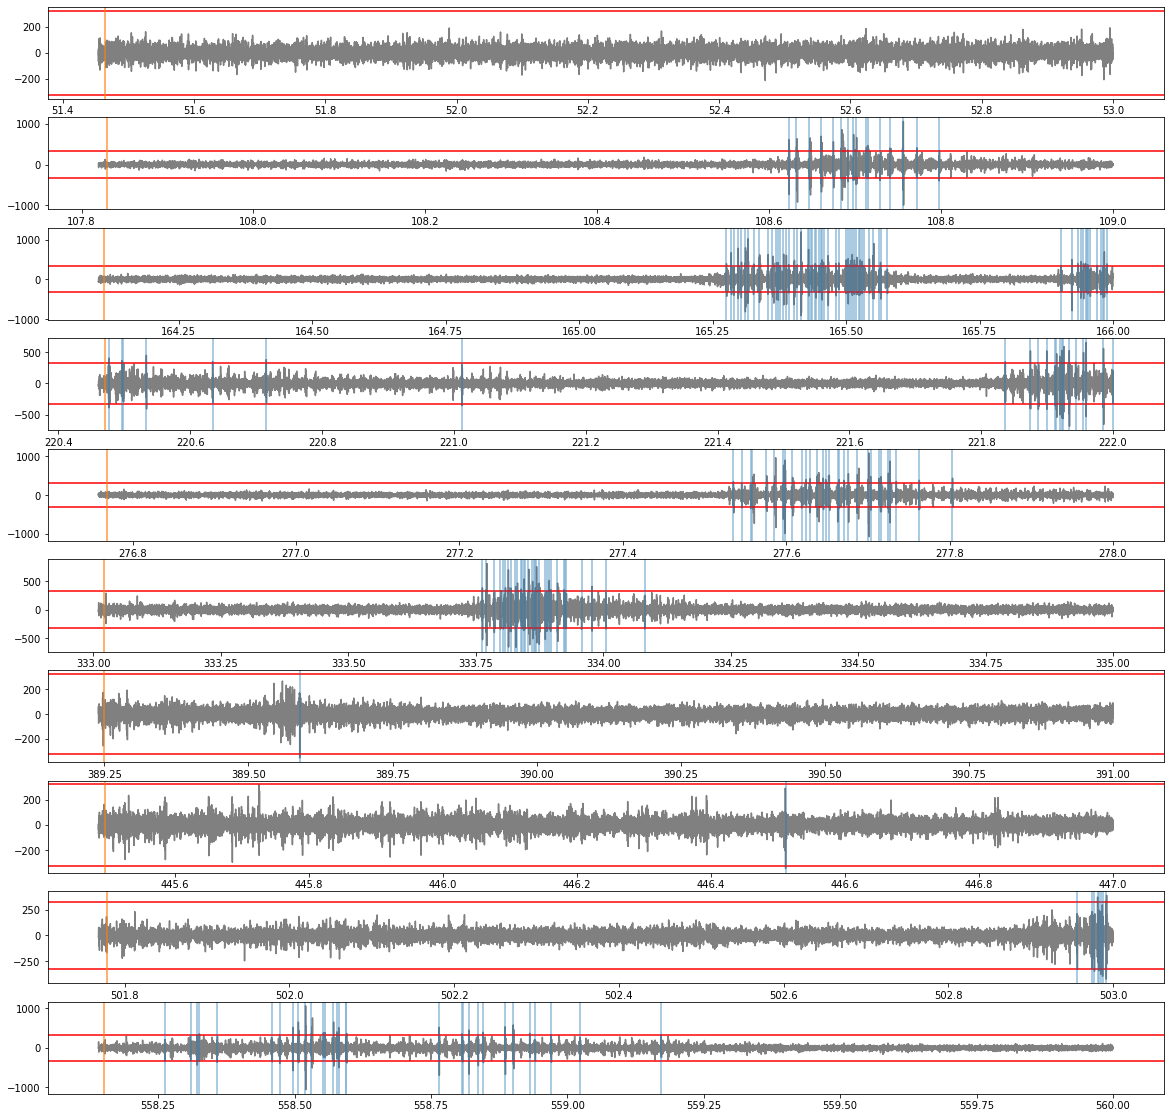

In [40]:
# Sanity check
# plot a channel after the presentation of a sound
SecAfterSound = 2
SoundID = 9
Channel = 19
nSounds = 10


SoundTimes = TTLs['soundPresentationTimes'][stimulus_order==SoundID][0:nSounds]


fig, axs = plt.subplots(nSounds, 1, figsize=(20, 2*nSounds) , facecolor='w', edgecolor='k', sharex=False)
fig.subplots_adjust(hspace = 0.2, wspace=.001)
#axs = axs.ravel()

for i in range(nSounds):
    PlotX = range(int(SamplingRate*(SoundTimes[i].item()-0.01)), int(SamplingRate)*(int(SoundTimes[i].item()+SecAfterSound)))
    axs[i].plot(AnalogSignals.times[PlotX], RSfilt[Channel][PlotX], alpha = 1, color = 'grey')
    axs[i].axhline(SD_cutoff*RefSignalsSD[Channel], color = 'red')
    axs[i].axhline(-SD_cutoff*RefSignalsSD[Channel], color = 'red')
    axvlines(SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[PlotX][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[PlotX][-1])], alpha=0.5, ax = axs[i])
    axvlines(SoundTimes[(SoundTimes>=AnalogSignals.times[PlotX][0]) & (SoundTimes<=AnalogSignals.times[PlotX][-1])], alpha=0.8, ax = axs[i])
    #print(i)
plt.show()

In [46]:
# Save the data
# Saving the objects:
try:
    # Create target Directory
    os.mkdir(OutputPath)
    print("Directory " , OutputPath ,  " Created ") 
except FileExistsError:
    print("Directory " , OutputPath ,  " already exists")
with open(OutputPath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '.pkl', 'wb') as f:
    pickle.dump([AnalogSignals.times, SignalsSpikes, TTLs], f)
    print("Data Saved")

Directory  /mnt/c/Users/herny/Desktop/SWC/Data/Ephys_data/SoundResponses/AnalyzedData/NN01/  already exists
Data Saved


In [48]:
# Getting back the objects: RUN THIS AS IT RENAMES VARIABLES
SD_cutoff = 4.5 #Select which processed data you want to load
SamplingRate = 30000
try:
    with open(OutputPath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '.pkl', 'rb') as f:
        timeValues, SignalsSpikes, TTLs = pickle.load(f)
except:
    print('These are the experiments I found:')
    for file in glob.glob(OutputPath+Experiment+'*_preProcessed_cutoff_*.pkl'):
        print(os.path.basename(file))

##### <br><br><br>Create raster plot and tuning curves for sound onset

In [25]:
# Calculate the spike times per sound ID and per channel aligned to the sound presentation

# Create a structure to hold the spikes: SpikesAlignedOnset[Channel][SoundID][nPresentation] -> list of spike times in window
SecBeforeSound = 0.5
SecAfterSound = 1
SpikesAlignedOnset = [None] * len(SignalsSpikes)
repOrSounds = len(stimulus_order)/len(set(stimulus_order))
Arr_unique, Arr_counts = np.unique(stimulus_order, return_counts=True)

for Channel in range(len(SpikesAlignedOnset)):
    SoundIDcounts = [None] * len(set(stimulus_order))
    for SoundID in set(stimulus_order):
        SoundIDidx = int(np.where(Arr_unique==SoundID)[0])
        Counts = [None] * Arr_counts[SoundIDidx]
        for i in range(len(Counts)):
            SoundTime = TTLs['soundPresentationTimes'][stimulus_order==SoundID][i]
            calcWindow = range(int(SamplingRate*(SoundTime.item()-SecBeforeSound)), int(SamplingRate*(SoundTime.item()+SecAfterSound)))
            Counts[i] = SignalsSpikes[Channel][(SignalsSpikes[Channel]>=timeValues[calcWindow][0]) & (SignalsSpikes[Channel]<=timeValues[calcWindow][-1])] - SoundTime           
            
        SoundIDcounts[SoundIDidx] = Counts
    SpikesAlignedOnset[Channel] = SoundIDcounts
    update_progress(Channel / len(SpikesAlignedOnset))
update_progress(1)

Progress: [####################] 100.0%


In [26]:
# Split the data by tetrode
# assumes they are in order
tetrodeList = np.arange(32).reshape(8,4)

# For neuronexus the same THIS ASSUMES THEY ARE IN ORDER AND THEY ARE NOT!!!!!
#tetrodeList = np.arange(64).reshape(4,16)
#each channel independently
tetrodeList = np.arange(64).reshape(64,1)


# create a general raster plot, removing spikes that ocurred after .3ms of another spike occurrence
# join the spikes of all electrodes
RasterOnsetList = [None] * len(tetrodeList)
counter2 = 0
for tetrode in tetrodeList:
    Raster = [None] * 100 # 10 sounds 10 times
    counter = 0
    for SoundID in range(len(SpikesAlignedOnset[0])):
        for nPres in range(len(SpikesAlignedOnset[0][0])):
            TetSpikes = [SpikesAlignedOnset[i] for i in tetrode]
            concVector = np.concatenate([item[SoundID][nPres] for item in TetSpikes])
            if len(concVector) > 0:
                Raster[counter] = getFirstPulses(np.sort(concVector), 0.0003)
            else:
                Raster[counter] = []
                    
            counter += 1   
    RasterOnsetList[counter2] = Raster
    counter2 += 1
    update_progress(tetrode / len(tetrodeList))
update_progress(1)

Progress: [####################] 100.0%


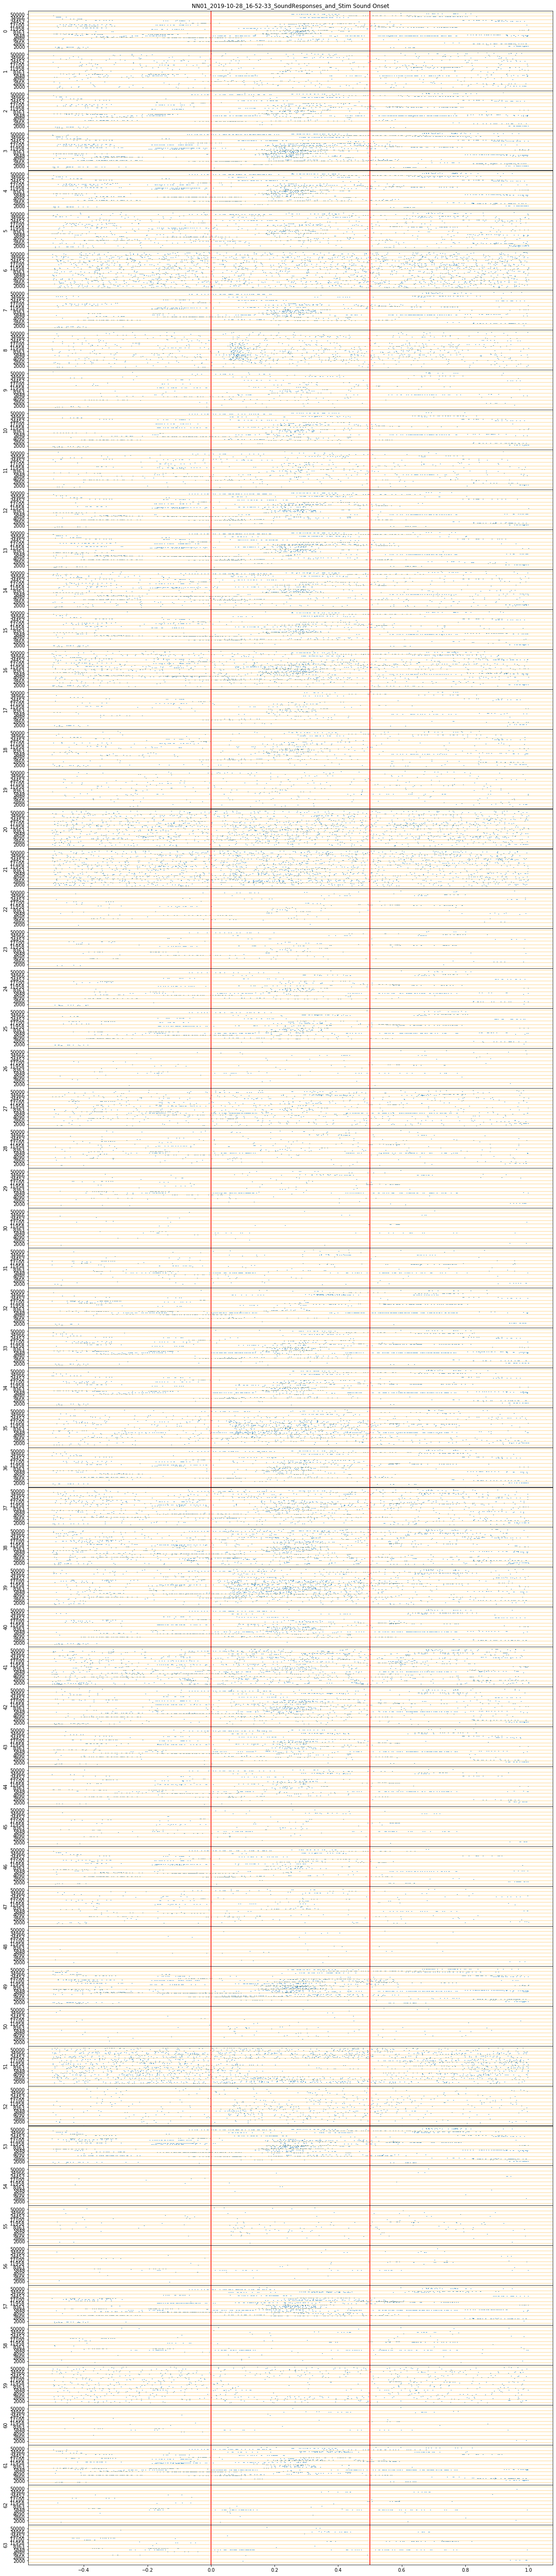

In [27]:
# plot the data
fig_an, ax_an = plt.subplots(len(RasterOnsetList),1,figsize=(20, 100), sharex=True)
fig_an.subplots_adjust(hspace = 0.001, wspace=.001)
if len(RasterOnsetList)>1:
    ax_an = ax_an.ravel()
for i in range(len(RasterOnsetList)):
    if len(RasterOnsetList)>1:
        PlotAxis = ax_an[i]
    else:
        PlotAxis = ax_an            
    try:
        PlotAxis.eventplot(RasterOnsetList[i])
        axvlines(0, ax = PlotAxis, color = 'red')
        axvlines(0.5, ax = PlotAxis, color = 'red') #DURATION OF SOUND!
        PlotAxis.set_ylabel(i)
        PlotAxis.set_yticks([5,15,25,35,45,55,65,75,85,95])
        PlotAxis.set_yticklabels([2000,2860,4090,5848,8363,11958,17100,24452,34966,50000])
        for j in range(11):
            PlotAxis.axhline(10*j, color = 'orange', alpha = 0.3)
    except:
        print(i)
if len(RasterOnsetList)>1:
    ax_an[0].set_title(Experiment + ' Sound Onset')
else:
    ax_an.set_title(Experiment + ' Sound Onset')
        
plt.savefig(OutputPath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '_tetrodes_raster_Onset.pdf', transparent=True, bbox_inches='tight')
plt.show()

##### <br>Create tuning curves for sound onset

In [62]:
# This part will calculate the firing rate with regards to the alignment (more than 0 and less than 0)
# so be careful how to use it

# calculate the firing rate per tetrode: FiringList[tetrode][SoundID][nPresentation]
FiringList = [None] * len(RasterOnsetList)
SilentList = [None] * len(RasterOnsetList)
MeansList = [None] * len(RasterOnsetList)
StimPresVectorGrouped = [x//10 for x in range(10,110)]

counter = 0
for i in range(len(RasterOnsetList)):
    tetrode = RasterOnsetList[i]
    FiringList[counter] = np.asarray([sum(np.array(x)>=0) for x in tetrode]) / SecAfterSound
    SilentList[counter] = np.asarray([sum(np.array(x)<0) for x in tetrode]) / SecBeforeSound
    MeansList[counter] = np.insert(np.mean(FiringList[counter].reshape(10,10), axis = 1), 0, np.mean(SilentList[counter]))
    counter += 1

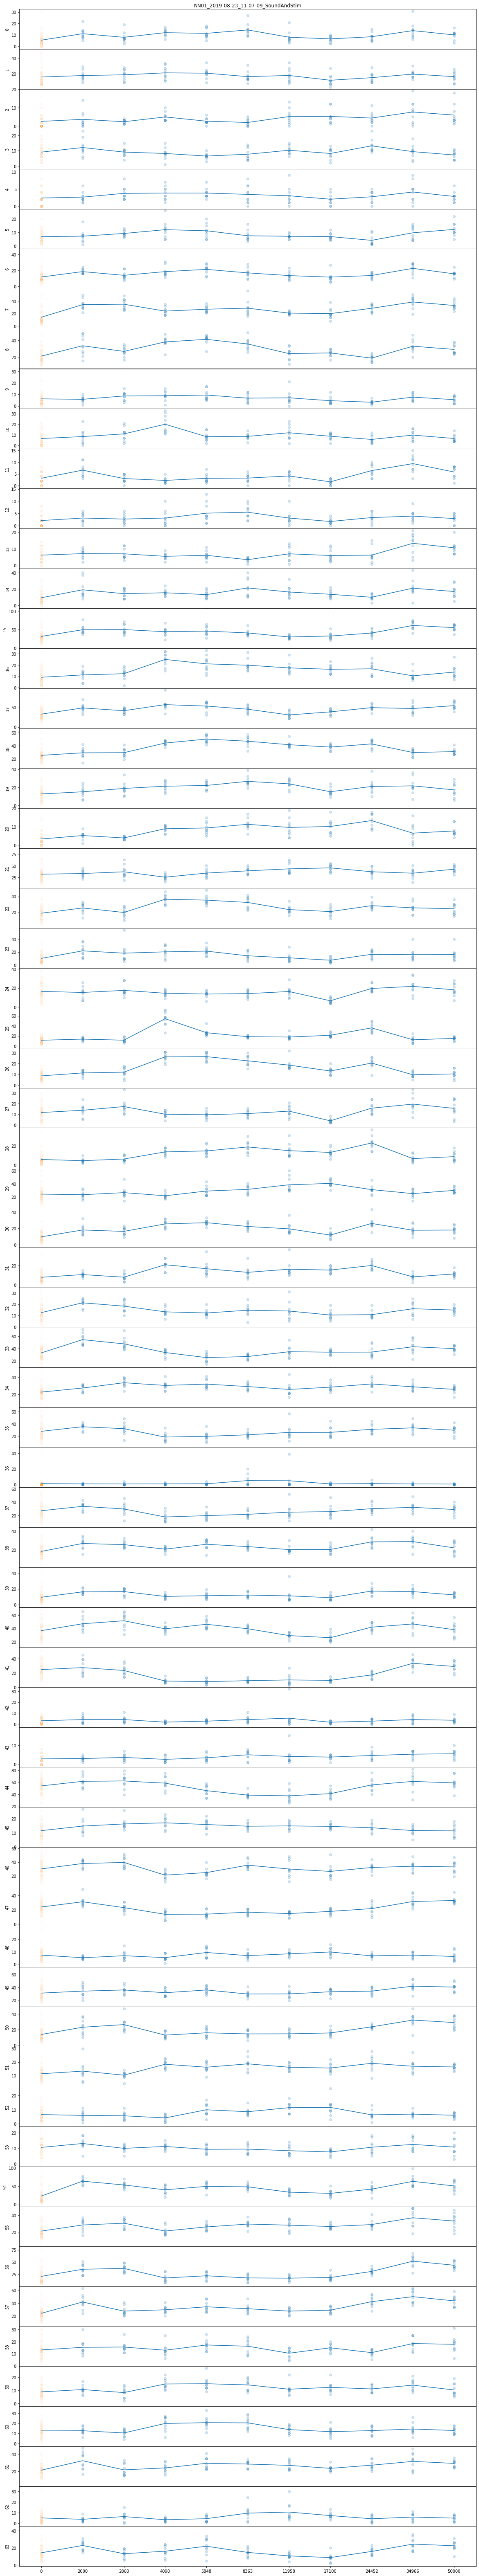

In [63]:
#plot
fig, axs = plt.subplots(len(FiringList), 1, figsize=(20, 115) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = 0.001, wspace=.001)
axs = axs.ravel()

for tetrode in range(len(FiringList)):
    axs[tetrode].scatter(StimPresVectorGrouped, FiringList[tetrode], alpha = 0.2)
    axs[tetrode].scatter([0] * len(SilentList[tetrode]), SilentList[tetrode], alpha = 0.01, color = 'orange')
    axs[tetrode].plot(MeansList[tetrode])
    axs[tetrode].set_ylabel(tetrode)
axs[tetrode].set_xticks([x for x in range(11)])
axs[tetrode].set_xticklabels([0,2000,2860,4090,5848,8363,11958,17100,24452,34966,50000])
axs[0].set_title(Experiment)
plt.savefig(OutputPath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '_shanks_tuningCurve_Onset.pdf', transparent=True, bbox_inches='tight')
plt.show()

##### <br><br>Create raster plot for sound offset

In [10]:
# Calculate the spike times per sound ID and per channel aligned to the sound offset
# Create a structure to hold the spikes: SpikesAlignedOffset[Channel][SoundID][nPresentation] -> list of spike times in window
SecBeforeSound = 0.15
SecAfterSound = 0.15
SpikesAlignedOffset = [None] * len(SignalsSpikes)
repOrSounds = len(stimulus_order)/len(set(stimulus_order))
Arr_unique, Arr_counts = np.unique(stimulus_order, return_counts=True)

for Channel in range(len(SpikesAlignedOffset)):
    SoundIDcounts = [None] * len(set(stimulus_order))
    for SoundID in set(stimulus_order):
        SoundIDidx = int(np.where(Arr_unique==SoundID)[0])
        Counts = [None] * Arr_counts[SoundIDidx]
        for i in range(len(Counts)):
            SoundTime = TTLs['soundOffsetTimes'][stimulus_order==SoundID][i]
            calcWindow = range(int(SamplingRate*(SoundTime.item()-SecBeforeSound)), int(SamplingRate*(SoundTime.item()+SecAfterSound)))
            Counts[i] = SignalsSpikes[Channel][(SignalsSpikes[Channel]>=timeValues[calcWindow][0]) & (SignalsSpikes[Channel]<=timeValues[calcWindow][-1])] - SoundTime           
            
        SoundIDcounts[SoundIDidx] = Counts
    SpikesAlignedOffset[Channel] = SoundIDcounts

In [11]:
# Split the data by tetrode
# assumes they are in order
#tetrodeList = np.arange(32).reshape(8,4)

# For neuronexus the same THIS ASSUMES THEY ARE IN ORDER AND THEY ARE NOT!!!!!
#tetrodeList = np.arange(64).reshape(4,16)
#each channel independently
tetrodeList = np.arange(64).reshape(64,1)


# create a general raster plot, removing spikes that ocurred after .3ms of another spike occurrence
# join the spikes of all electrodes
RasterOffsetList = [None] * len(tetrodeList)
counter2 = 0
for tetrode in tetrodeList:
    Raster = [None] * 100 # 10 sounds 10 times
    counter = 0
    for SoundID in range(len(SpikesAlignedOffset[0])):
        for nPres in range(len(SpikesAlignedOffset[0][0])):
            TetSpikes = [SpikesAlignedOffset[i] for i in tetrode]
            concVector = np.concatenate([item[SoundID][nPres] for item in TetSpikes])
            if len(concVector) > 0:
                Raster[counter] = getFirstPulses(np.sort(concVector), 0.0003)
            else:
                Raster[counter] = []
                    
            counter += 1   
    RasterOffsetList[counter2] = Raster
    counter2 += 1

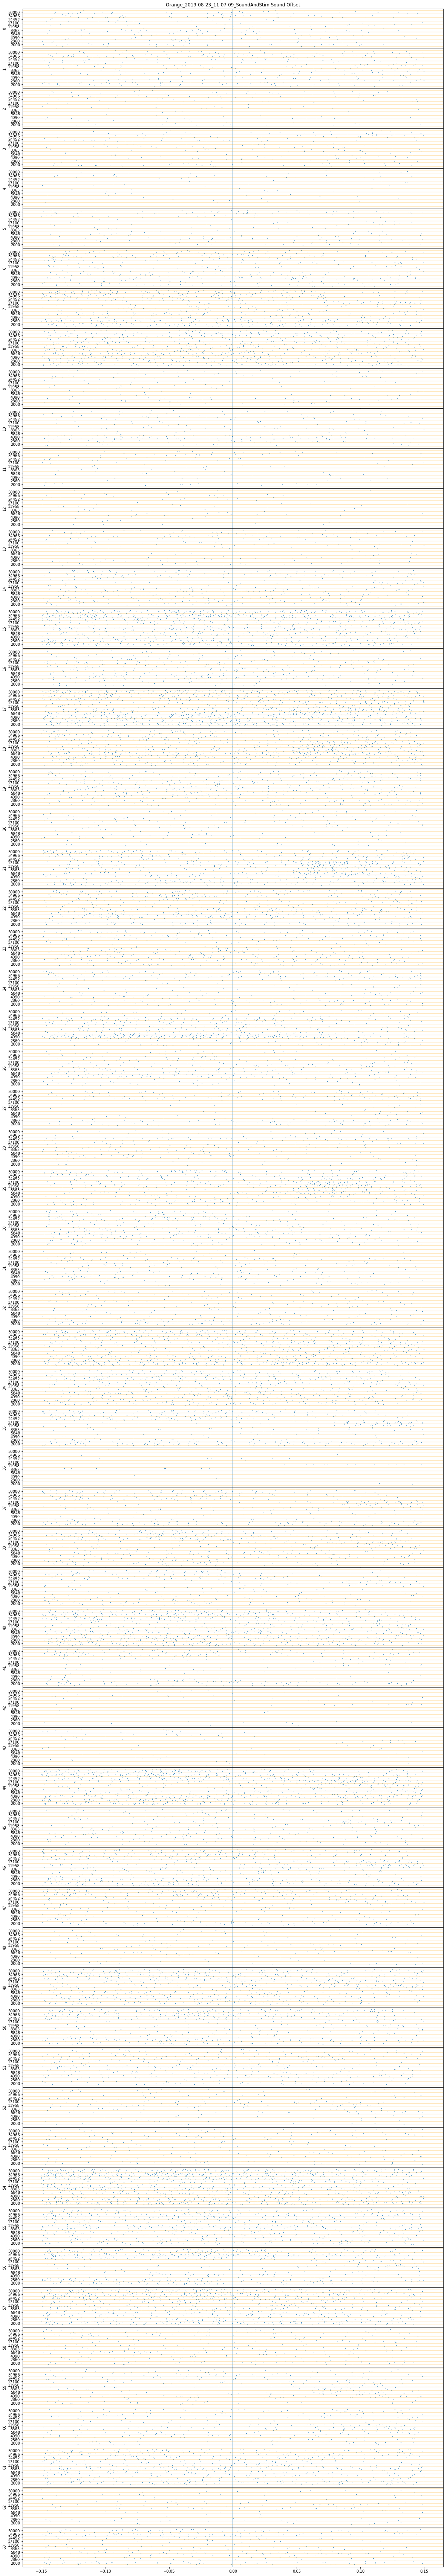

In [12]:
# plot the data
fig_an, ax_an = plt.subplots(len(RasterOffsetList),1,figsize=(20, 125), sharex=True)
fig_an.subplots_adjust(hspace = 0.001, wspace=.001)
if len(RasterOffsetList)>1:
    ax_an = ax_an.ravel()
for i in range(len(RasterOffsetList)):
    if len(RasterOffsetList)>1:
        PlotAxis = ax_an[i]
    else:
        PlotAxis = ax_an            
    try:
        PlotAxis.eventplot(RasterOffsetList[i])
        axvlines(0, ax = PlotAxis)
        PlotAxis.set_ylabel(i)
        PlotAxis.set_yticks([5,15,25,35,45,55,65,75,85,95])
        PlotAxis.set_yticklabels([2000,2860,4090,5848,8363,11958,17100,24452,34966,50000])
        for j in range(11):
            PlotAxis.axhline(10*j, color = 'orange', alpha = 0.3)
    except:
        print(i)
if len(RasterOffsetList)>1:
    ax_an[0].set_title(Experiment + ' Sound Offset')
else:
    ax_an.set_title(Experiment + ' Sound Offset')
        
plt.savefig(OutputPath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '_shanks_raster_Offset.pdf', transparent=True, bbox_inches='tight')
plt.show()

##### <br><br>Create raster plot and histogram count for stimulation

In [28]:
# Create a structure to hold the spikes: SpikesAlignedStim[Channel][nPresentation] -> list of spike times in window
SecBeforeStim = 0.5
SecAfterStim = 0.7
# align to the first pulse
PulseToAlign = getFirstPulses(TTLs['stimTimes'], 0.11)
SpikesAlignedStim = alignSpikes(SignalsSpikes, PulseToAlign, [SecBeforeStim, SecAfterStim])

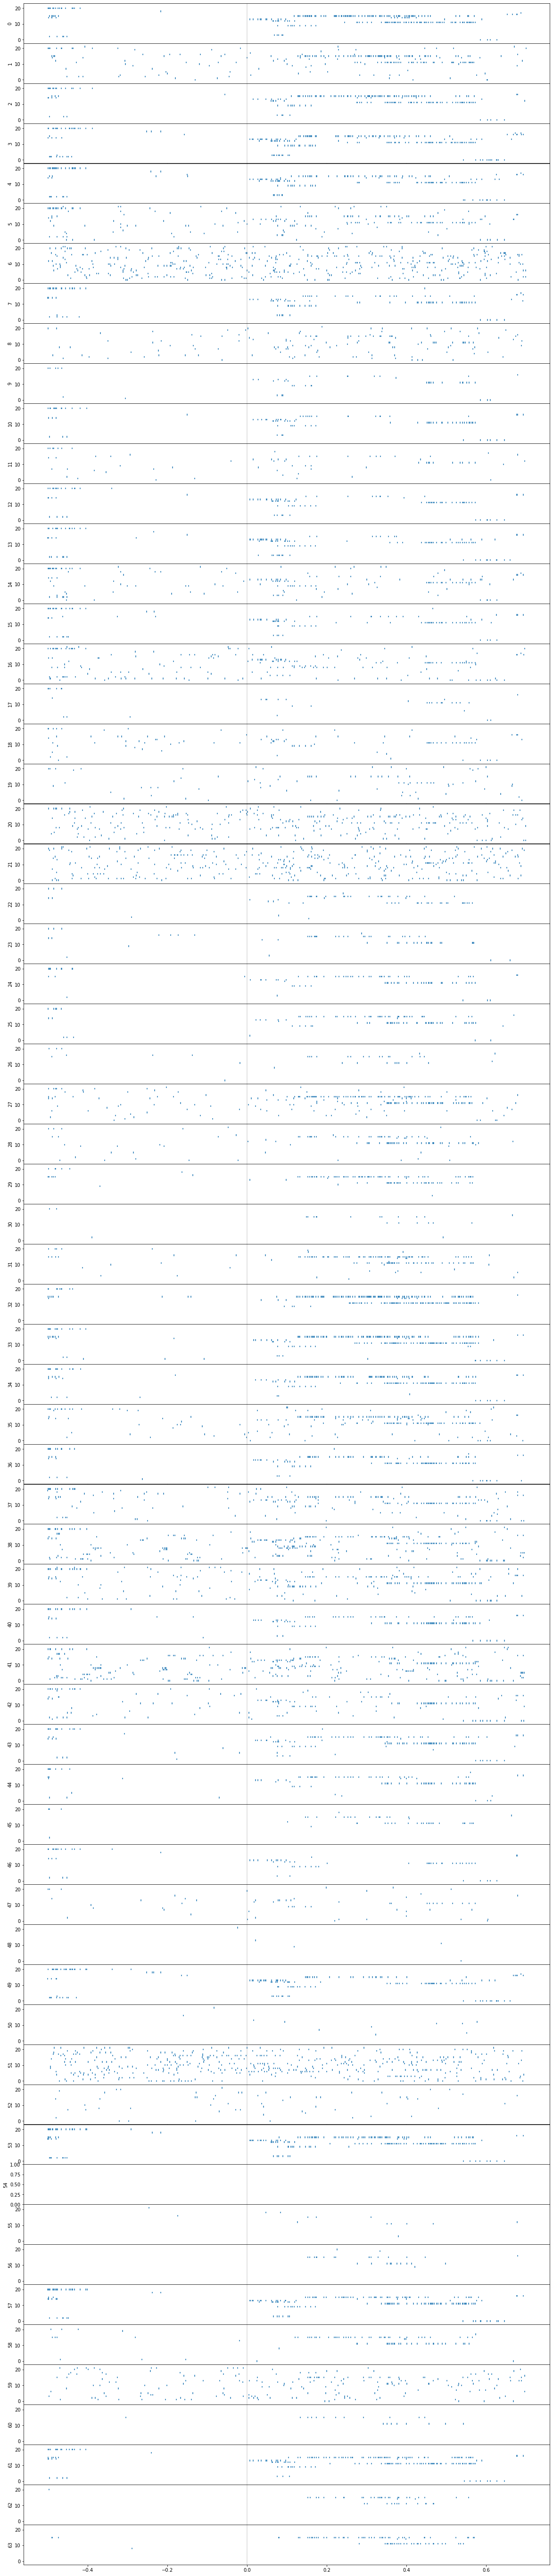

In [29]:
# plot
fig_an, ax_an = plt.subplots(len(SpikesAlignedStim),1,figsize=(20, 100), sharex=True)
fig_an.subplots_adjust(hspace = 0.001, wspace=.001)
ax_an = ax_an.ravel()
for i in range(len(SpikesAlignedStim)):
    if len(SpikesAlignedStim)>1:
        PlotAxis = ax_an[i]
    else:
        PlotAxis = ax_an            

    PlotAxis.eventplot(SpikesAlignedStim[i])
    axvlines(0, ax = PlotAxis, alpha = 0.3, color='grey')
    PlotAxis.set_ylabel(i)
plt.savefig(OutputPath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '_optotag.pdf', transparent=True, bbox_inches='tight')
plt.show()

##### <br><br>Deprecated

In [16]:
# create a general raster plot, removing spikes that ocurred after .3ms of another spike occurrence
# join the spikes of all electrodes
Raster = [None] * 100 # 10 sounds 10 times
counter = 0
for SoundID in range(len(SpikesAligned[0])):
    for nPres in range(len(SpikesAligned[0][0])):
        concVector = np.concatenate([item[SoundID][nPres] for item in SpikesAligned])
        Raster[counter] = getFirstPulses(np.sort(concVector), 0.0003)
        #Raster[counter] = np.sort(concVector)
        counter += 1   

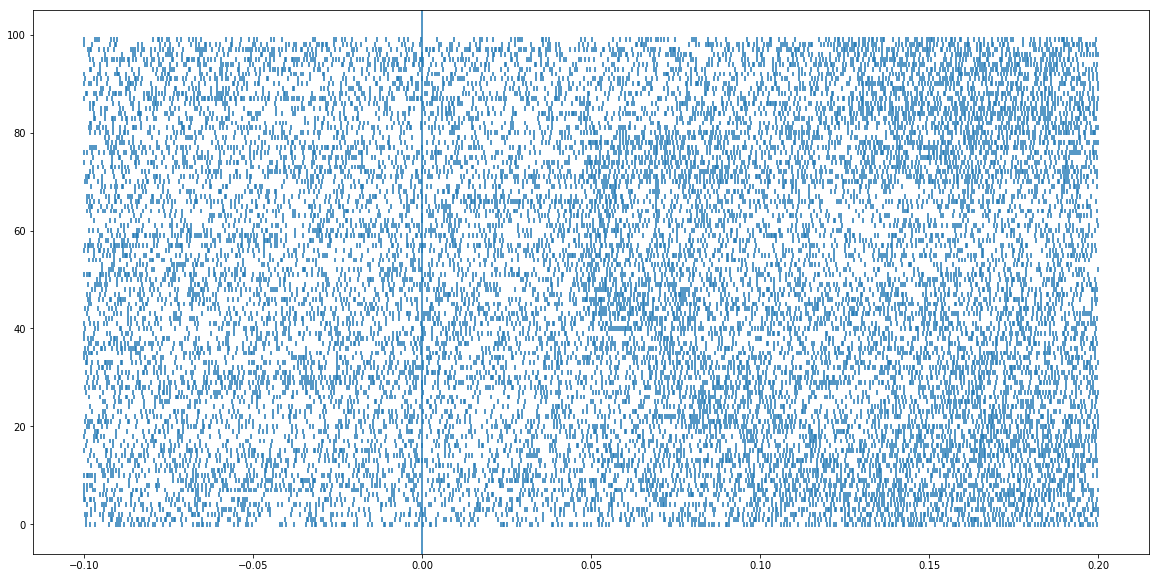

In [11]:
# plot
fig_an, ax_an = plt.subplots(figsize=(20, 10))
ax_an.eventplot(Raster)
axvlines(0)
#plt.savefig(OEpath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '_raster.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [33]:
# Calculate the spike count directly FirRate[Channel] = [ ,  ,  , ...] -> spike counts in order of the sound presentation
# Calculate the silent time firing rate
#SecAfterSound = 0.3
FiringRateList = [None] * 32
SilentRateList = [None] * 32
for Channel in range(32):
    FiringRate = [None] * len(stimulus_order)
    SilentRate = [None] * len(stimulus_order)
    for SoundPresentation in range(len(stimulus_order)):
        calcWindowF = range(int(30000*(soundPresentationTimes[SoundPresentation].item())), int(30000*(soundPresentationTimes[SoundPresentation].item()+SecAfterSound)))
        calcWindowS = range(int(30000*(soundPresentationTimes[SoundPresentation].item()-SecAfterSound)), int(30000*(soundPresentationTimes[SoundPresentation].item())))
        FiringRate[SoundPresentation] = len(SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[calcWindowF][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[calcWindowF][-1])]) / SecAfterSound    
        SilentRate[SoundPresentation] = len(SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[calcWindowS][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[calcWindowS][-1])]) / SecAfterSound    
    
    FiringRateList[Channel] = FiringRate
    SilentRateList[Channel] = SilentRate

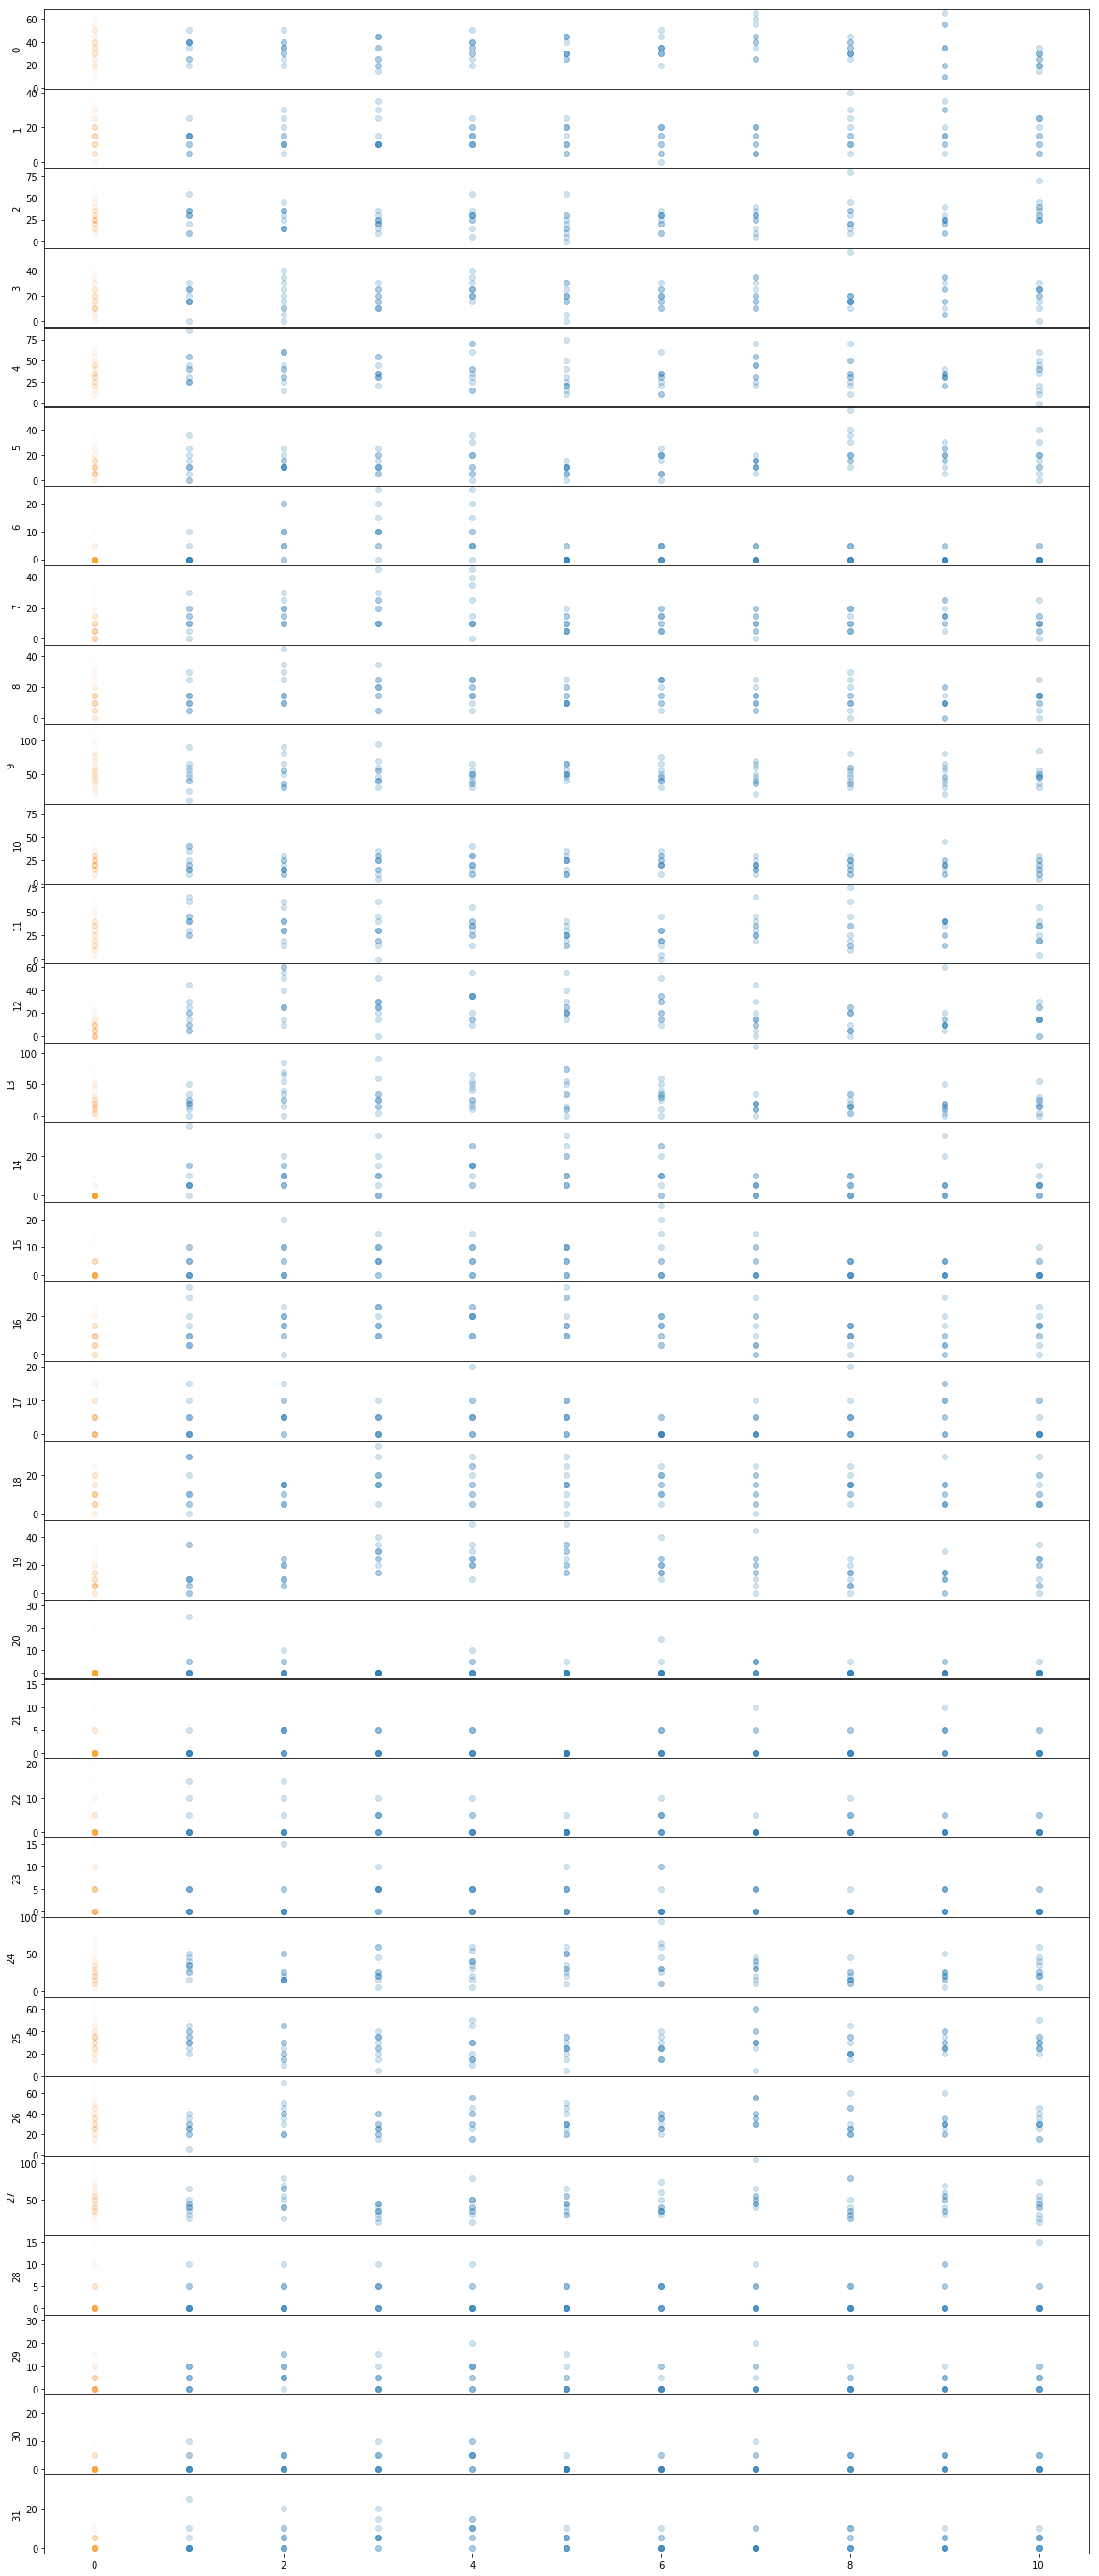

In [34]:
fig, axs = plt.subplots(32, 1, figsize=(20, 50) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = 0.001, wspace=.001)
axs = axs.ravel()

for Channel in range(32):
    axs[Channel].scatter(stimulus_order, FiringRateList[Channel], alpha = 0.2)
    axs[Channel].scatter([0] * len(SilentRateList[Channel]), SilentRateList[Channel], alpha = 0.01, color = 'orange')
    axs[Channel].set_ylabel(Channel)
plt.savefig(OutputPath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '.pdf', transparent=True, bbox_inches='tight')
plt.show()


###### 